In [1]:
# load data and take a quick look
import re
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

raw_data = pd.read_csv('urdu_v1.tsv', sep ='\t')
raw_data.head(5)

,Tweet,Class
0,میں نے ایٹم بم بنایا ھے ۔۔۔۔او بھائی ایٹم بمب ...,P
1,چندے سے انقلاب اور عمران خان وزیر اعظم نہیں بن...,N
2,ٹویٹر کا خیال کیسے آیا ؟,O
3,"سرچ انجن گوگل کے نائب صدر نے فضا میں ، 130,000...",P
4,ابھی تک اسکی لہریں کبھی کبھی آ جاتی ہیں یار :أْ,P


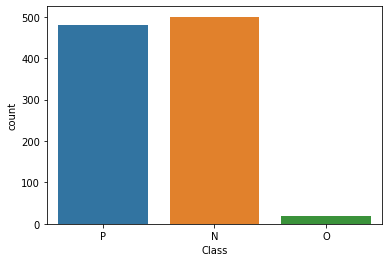

In [2]:
# check the size of the data and its class distribution
sentences = raw_data['Tweet'].tolist()
sentiments = raw_data['Class'].tolist()

sns.countplot(x='Class', data=raw_data)
plt.show()

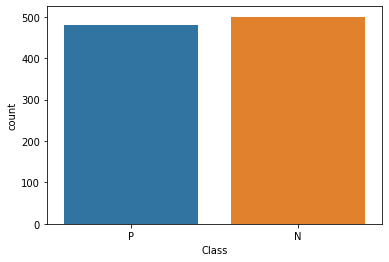

In [3]:
indexNames = raw_data[raw_data['Class'] == "O"].index
raw_data.drop(indexNames, inplace=True)
sns.countplot(x='Class', data=raw_data)
plt.show()

In [4]:
# text cleaning and pre-processing:
def delete_urdu_english_symbols(sentences):
    cleaned = []
    for sentence in sentences:
        text = re.sub(r"\d+", " ", sentence)
        # English punctuations
        text = re.sub(r"""[!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~]+""", " ", text)
        # Urdu punctuations
        text = re.sub(r"[:؛؟’‘٭ء،۔]+", " ", text)
        # Arabic numbers
        text = re.sub(r"[٠‎١‎٢‎٣‎٤‎٥‎٦‎٧‎٨‎٩]+", " ", text)
        text = re.sub(r"[^\w\s]", " ", text)
        # Remove English characters and numbers.
        text = re.sub(r"[a-zA-z0-9]+", " ", text)
        # remove multiple spaces.
        text = re.sub(r" +", " ", text)
        text = text.split(" ")
        # some stupid empty tokens should be removed.
        text = [t.strip() for t in text if t.strip()]
        cleaned.append(" ".join(text))
    return cleaned

X = delete_urdu_english_symbols(sentences)
Y = sentiments

In [5]:
# Feel free to use different ratios to split the data.
train_text, test_text, train_labels, test_labels = train_test_split(X, Y, test_size=0.20, random_state=42)

In [6]:
# training: tf-idf + logistic regression
max_feature_num = 5000
train_vectorizer = TfidfVectorizer(max_features=max_feature_num)
train_vecs = train_vectorizer.fit_transform(train_text)
test_vecs = TfidfVectorizer(max_features=max_feature_num,vocabulary=train_vectorizer.vocabulary_).fit_transform(test_text)

# train model
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression().fit(train_vecs, train_labels)

# test model
test_pred = clf.predict(test_vecs)
from sklearn.metrics import precision_recall_fscore_support,accuracy_score
acc = accuracy_score(test_labels, test_pred)
pre, rec, f1, _ = precision_recall_fscore_support(test_labels, test_pred, average='macro')
print('acc', acc)
print('precision', pre)
print('rec', rec)
print('f1', f1)

acc 0.59
precision 0.4026920528646651
rec 0.40702593979747537
f1 0.39529751294457177


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [7]:
import pickle

# save model and other necessary modules
all_info_want_to_save = {
    'model': clf,
    'vectorizer': TfidfVectorizer(max_features=max_feature_num,vocabulary=train_vectorizer.vocabulary_)
}
save_path = open("sentiment_urdu_logistic_regression.pickle","wb")
pickle.dump(all_info_want_to_save, save_path)

In [8]:
# Update the model path and use new data file

import pickle

model_path = '/content/sentiment_urdu_logistic_regression.pickle'

# reload your model and use it to make predictions for test text
# you should adjust the code so as to load to your saved model/components
def test_trained_model(model_path, test_text):
    saved_model_dic = pickle.load(open(model_path,"rb"))
    saved_clf = saved_model_dic['model']
    saved_vectorizer = saved_model_dic['vectorizer']
    print(len(saved_vectorizer.vocabulary))
    new_test_vecs = saved_vectorizer.fit_transform(test_text)
    return saved_clf.predict(new_test_vecs)


# load sample test data
import pandas as pd
test_data = pd.read_csv('/content/urdu_v1.tsv', delimiter = '\t')
test_text = test_data['Tweet'].tolist()[-5000:]
test_labels = test_data['Class'].tolist()[-5000:]

print('test data size', len(test_labels))

# test model
from sklearn.metrics import precision_recall_fscore_support,accuracy_score
new_test_pred = test_trained_model("sentiment_urdu_logistic_regression.pickle", test_text)
acc = accuracy_score(test_labels, new_test_pred)
pre, rec, f1, _ = precision_recall_fscore_support(test_labels, new_test_pred, average='macro')
print('acc', acc)
print('precision', pre)
print('rec', rec)
print('f1', f1)

test data size 1000
4349
acc 0.883
precision 0.5906875431331953
rec 0.6000555555555556
f1 0.5942867444604694


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
